./output/sv_500_1.wav
./output/statevar_500_1.wav
./output/moogladder_5000_1.wav
./output/moogladder_1000_1.wav
./output/sv_5000_10.wav
./output/moogladder_500_10.wav
./output/statevar_1000_10.wav
./output/sv_1000_1.wav
./output/moogladder_1000_10.wav
./output/sv_5000_1.wav
./output/moogladder_500_1.wav
./output/moogladder_500_2.wav
./output/statevar_500_10.wav
./output/statevar_500_2.wav
./output/moogladder_5000_10.wav
./output/statevar_5000_10.wav
./output/statevar_1000_1.wav
./output/sv_500_10.wav
./output/statevar_5000_1.wav
./output/statevar_1000_2.wav
./output/statevar_5000_2.wav
./output/moogladder_1000_2.wav
./output/sv_1000_10.wav
./output/moogladder_5000_2.wav
./output/sv_1000_2.wav
./output/sv_500_2.wav
./output/sv_5000_2.wav
./output/moogladder_500_3.wav
./output/moogladder_1000_3.wav
./output/moogladder_5000_3.wav
./output/statevar_5000_3.wav
./output/statevar_500_3.wav
./output/statevar_1000_3.wav
./output/sv_500_3.wav
./output/sv_1000_3.wav
./output/sv_5000_3.wav
./outpu

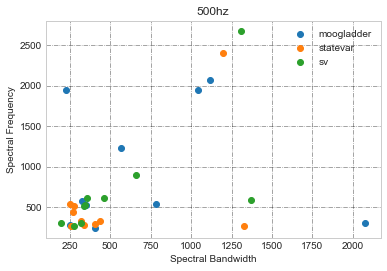

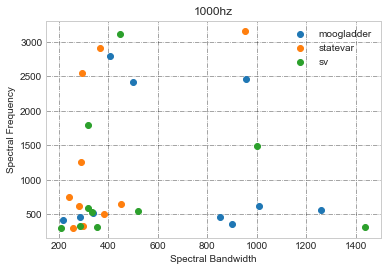

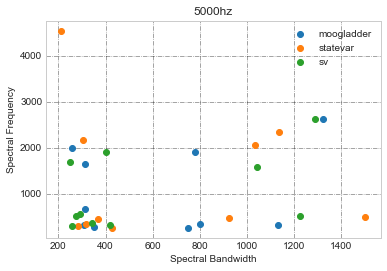

In [1]:
import ctcsound
import numpy as np
import librosa
import matplotlib.pyplot as plt
import matplotlib.style as ms
import os
import pandas as pd
import concurrent.futures

ms.use('seaborn-whitegrid')

input_file_dir = './input/'
output_file_dir = "./output/"

number_of_threads = 24

def get_bandwidth(sample_data):
    return np.mean(librosa.feature.spectral_bandwidth(sample_data))

def get_rolloff(sample_data):
    return np.mean(librosa.feature.spectral_rolloff(sample_data))

# ------------------------------------------------------ #
# ------------------ Pandas Functions ------------------ #
# ------------------------------------------------------ #

def get_unique_labels_pandas(database: pd.DataFrame):
    unique_labels = list(database['filter'].unique())
    unique_labels.sort()
    return unique_labels


def analysis_thread(filename):
    global bandwidth
    global rolloff
    current_sample = get_mono_resampled_audio(filename)
    print("Generating bandwidth for: {}...".format(filename))
    bandwidth.append(get_bandwidth(current_sample))
    print("Generating rolloff for: {}...".format(filename))
    rolloff.append(get_rolloff(current_sample))
    print("Done")


def set_metadata_pandas(database: pd.DataFrame):
    global bandwidth
    global rolloff
    global number_of_threads
    bandwidth = []
    rolloff = []
    filenames = list(database['filename'])

    with concurrent.futures.ThreadPoolExecutor(max_workers=number_of_threads) as executor:
        executor.map(analysis_thread, filenames)

    database['bandwidth'] = bandwidth
    database['rolloff'] = rolloff


def plot_pandas(database, x_key, y_key, x_label, y_label, title, out_filename):
    unique_labels = get_unique_labels_pandas(database)
    # for each instrument
    for current_label in unique_labels:
        current_instrument_data = database[database['filter'] == current_label]
        plt.scatter(current_instrument_data[x_key], current_instrument_data[y_key], label=current_label)

    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.legend()
    plt.savefig(out_filename)
    plt.grid(color='black', linestyle='-.', linewidth=0.7, alpha=0.5)
    plt.title(title)
    plt.show()

# ------------ End Pandas Functions --------------------- #

def get_mono_resampled_audio(audio_filename):
    global output_file_dir
    target_sr = 44100
    y, original_sr = librosa.load(output_file_dir + audio_filename, sr=None, mono=False)

    # check if stereo, convert to mono if it is
    if len(y.shape) == 2 and y.shape[0] == 2:
        #print("Converting to Mono...")
        y = librosa.to_mono(y)

    # check if not 44100, resample if it is
    if original_sr != target_sr:
        #print("Resampling from {0} to {1}".format(original_sr, target_sr))
        y = librosa.resample(y, original_sr, target_sr)

    return y

def get_dataframes (filepath):

    dataframe = pd.DataFrame()
    filenames = os.listdir(filepath)
    for current_filename in filenames:
        dataframe = dataframe.append({
            'filename': current_filename
        }, ignore_index=True)
        # check the next filename
    return dataframe


def write_sound(input_filename, output_filename, filter, cutoff_frequency, duration = 2):
    #changing one parameter while performing (different frequency every second)
    cs = ctcsound.Csound()

    sco = 'i1 0 {}'.format(duration) #defining the score

    cs.readScore(sco) # read the score from pre-written String

    err = cs.compileCsd("./{}.csd".format(filter)) #try with saw2.csd for a sawtooth wave
    cs.setMessageLevel(4)
    cs.setOption("-o{}".format(output_filename))
    print(output_filename)
    cs.setStringChannel('filename', input_filename)
    cs.setControlChannel('cutoff', cutoff_frequency)

    cs.start()
    cs.perform()
    cs.reset()


def generate_output_filename(current_filter, current_frequency, current_filename):
    return "{}_{}_{}".format(current_filter, current_frequency, current_filename)


def generate_soundfiles(input_filenames, filters, cutoff_frequencies):
    global input_file_dir
    global output_file_dir
    global number_of_threads

    if not os.path.exists(output_file_dir):
        os.makedirs(output_file_dir)

    dataframe = pd.DataFrame()

    thread_input_filenames = []
    thread_output_filenames = []
    thread_current_filters = []
    thread_current_frequencies = []
    thread_durations = []

    for current_filename in input_filenames:
        for current_filter in filters:
            for current_frequency in cutoff_frequencies:
                input_filename = "{}{}".format(input_file_dir, current_filename)
                output_filename = generate_output_filename(current_filter, current_frequency, current_filename)
                duration = librosa.get_duration(filename=input_filename)
                thread_input_filenames.append(input_filename)
                thread_output_filenames.append(output_file_dir + output_filename)
                thread_current_filters.append(current_filter)
                thread_current_frequencies.append(current_frequency)
                thread_durations.append(duration)
                # write_sound(input_filename, output_file_dir + output_filename, current_filter, current_frequency, duration)
                dataframe = dataframe.append({
                    'filename': output_filename,
                    'filter': current_filter,
                    'frequency': current_frequency,
                }, ignore_index=True)

    with concurrent.futures.ThreadPoolExecutor(max_workers=number_of_threads) as executor:
        executor.map(write_sound, thread_input_filenames, thread_output_filenames, thread_current_filters, thread_current_frequencies, thread_durations)

    return dataframe


def run_wenbo():
    global input_file_dir
    global output_file_dir

    frequencies = [500, 1000, 5000]
    filters = ['moogladder', 'statevar', 'sv']

    # Generating the files and metadata takes forever so if we've already
    # created the csv by running it before, we can just load it and
    # create the plots
    read_csv = False

    if read_csv is False:
        # 1. Choose 10 songs from your computer.
        input_pandas_df = get_dataframes(input_file_dir)

        # 2. Generate 9 files for each song. These will be statvar lowpass (5khz, 1khz, 500hz), moogladder lowpass (5khz, 1khz, 500hz) and svfilter lowpass (5khz, 1khz, 500hz)
        filenames = input_pandas_df['filename'].tolist()
        output_pandas_df = generate_soundfiles(filenames, filters, frequencies)

        # 3. Calculate the Spectral Bandwidth and Spectral Roll-Off of these 9 files.
        set_metadata_pandas(output_pandas_df)
        output_pandas_df.to_csv("outmeta.csv", index=False)
    else:
        output_pandas_df = pd.read_csv("outmeta.csv")

    # 4. Make a plot for each frequency (5khz/1khz/500hz) and plot the spectral bandwidth vs spectral rolloff for each filter (statvar, moogladder, svfilter)
    for frequency in frequencies:
        current_frequency_pandas = output_pandas_df[output_pandas_df['frequency'] == frequency]
        plot_pandas(current_frequency_pandas, 'bandwidth', 'rolloff', "Spectral Bandwidth", "Spectral Frequency", "{}hz".format(frequency), "{}.png".format(frequency))

if __name__ == "__main__":
    run_wenbo()
